## Basic properties of object selectivity
This code analyzes basic properties of object selectivity

In [2]:
import os
from pathlib import Path
import numpy as np
import pandas as pd

from scipy import stats
import statsmodels.api as sm

import pingouin as pg

import matplotlib as mpl
import matplotlib.pyplot as plt  

from datetime import date
import time

import h5py

In [3]:
# no top and right spines in all plots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [4]:
mother_path = Path('D:/Multi-modal project/')
fig_path = mother_path / 'analysis' / 'result' / 'figures'

### Parameter setting

In [5]:
gauss_sigma = 2

# colors for multimodal, vis-only, aud-only conditions
color = ['mediumorchid','cornflowerblue','lightcoral','gray']
color2 = ['cyan','magenta','gray']
linestyle = ['-',':']

today = str(date.today())

### Data preparation

In [6]:
save_path = mother_path /'analysis'/'result'/'4. Temporal patterns of object selectivity'/today

cell_path = mother_path/'analysis'/'result'/'zFR export'/'13-Apr-2022 (5 trials)'
cell_list = os.listdir(cell_path)

# load hdf5 files containing shuffled results
data_path = mother_path /'analysis'/'result'/'3. ANOVA'/'2023-06-26'
data2_path = mother_path /'analysis'/'result'/'3.1 Multiple linear regression'/'2023-06-26'
f = h5py.File(data_path/'2023-06-26_ANOVA_result.hdf5','r')
f2 = h5py.File(data2_path/'2023-06-26_multiple_regression_result.hdf5','r')

In [7]:
def h5_to_df(f):
    keys = list(f.keys())
    attributes = {}
    
    for key in keys:
        attributes[key] = dict(f[key].attrs.items())
    
    df = pd.DataFrame.from_dict(attributes, orient='index')
    df.index.name = 'key'
    df = df.reset_index()
    
    return df

In [8]:
df = h5_to_df(f2)
df = df[(df['Region']=='PER')&(df['Response cell']==0)]
df.reset_index(inplace=True,drop=True)

object_bin_all = np.zeros((0,90))

for key in df['key']:    
    df.loc[df['key']==key,'pref_obj'] = f[key].attrs['Preferred object']
    df.loc[df['key']==key,'peak_selectivity'] = np.max(f[f'{key}/anova_eta'])  
    df.loc[df['key']==key,'peak_selectivity_time'] = np.argmax(f[f'{key}/anova_eta'])*10
    df.loc[df['key']==key,'selectivity_duration'] = len(f[f'{key}/object_bin'])*10
    df.loc[df['key']==key,'selectivity_onset'] = np.min(f[f'{key}/object_bin'])*10
    df.loc[df['key']==key,'selectivity_index'] = np.abs(f[key].attrs['Selectivity index'])
    
    object_bin = np.zeros((1,90))
    object_bin[0,f[f'{key}/object_bin']] = 1
    object_bin_all = np.append(object_bin_all, [object_bin[0]], axis=0)   
    
df['peak_selectivity_time_range'] = (df['peak_selectivity_time'] // 100) + 1
df['selectivity_onset_range'] = (df['peak_selectivity_time'] // 100) + 1
    
bin_sorted_peak = object_bin_all[np.argsort(df['peak_selectivity_time']),:]
bin_sorted_onset = object_bin_all[np.argsort(df['selectivity_onset']),:]

In [9]:
for i in range(len(df)):
    if df.loc[i,'peak_selectivity_time'] < 200:
        df.loc[i,'peak_selectivity_time_range2'] = 0
    elif 200 <= df.loc[i,'peak_selectivity_time'] < 400:
        df.loc[i,'peak_selectivity_time_range2'] = 1
    elif 400 <= df.loc[i,'peak_selectivity_time'] < 650:
        df.loc[i,'peak_selectivity_time_range2'] = 2
    elif 650 <= df.loc[i,'peak_selectivity_time'] < 900:
        df.loc[i,'peak_selectivity_time_range2'] = 3

### Temporal patterns of object selectivity

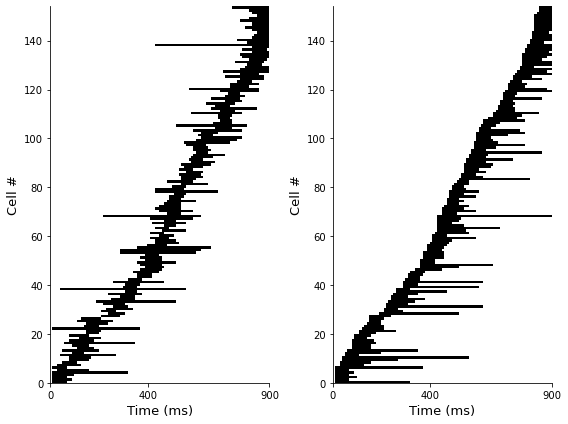

In [59]:
fig,ax = plt.subplots(1,2,figsize=(8,6))

ax[0].pcolor(bin_sorted_peak,cmap='binary')
ax[0].set_xticks([0,40,90])
ax[0].set_xticklabels([0,400,900])
ax[0].set_xlabel('Time (ms)',fontsize=13)
ax[0].set_ylabel('Cell #',fontsize=13)

ax[1].pcolor(bin_sorted_onset,cmap='binary')
ax[1].set_xticks([0,40,90])
ax[1].set_xticklabels([0,400,900])
ax[1].set_xlabel('Time (ms)',fontsize=13)
ax[1].set_ylabel('Cell #',fontsize=13)

plt.tight_layout()
plt.savefig(fig_path / 'population_selectivity.png', dpi=300,facecolor='white')

K-S test with uniform distribution
KS statistic: 0.15248796147672555
P-value: 0.0013631237254980496


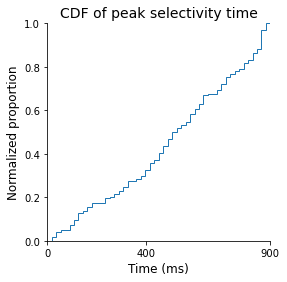

In [11]:
fig,ax = plt.subplots(figsize=(4,4))

ax.hist(df['peak_selectivity_time'], range=(0,900), bins=50, cumulative=1, histtype='step', density=True);

ax.set_ylim([0,1])
ax.set_xticks([0,400,900])
ax.set_xlim([0,900])
ax.set_ylabel('Normalized proportion',fontsize=12);
ax.set_xlabel('Time (ms)',fontsize=12);
ax.set_title('CDF of peak selectivity time',fontsize=14);

s,p = stats.kstest(df['peak_selectivity_time'], stats.uniform(loc=0, scale=890).cdf)
print('========================================================')
print("K-S test with uniform distribution")
print(f"KS statistic: {s}")
print(f"P-value: {p}")
print('========================================================')

K-S test with uniform distribution
KS statistic: 0.10656990068754774
P-value: 0.056139494736370255


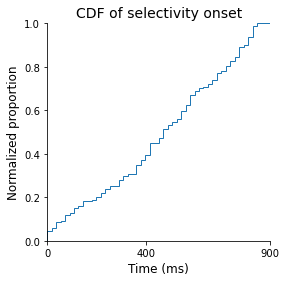

In [12]:
fig,ax = plt.subplots(figsize=(4,4))

ax.hist(df['selectivity_onset'], range=(0,900), bins=50, cumulative=1, histtype='step', density=True);

ax.set_ylim([0,1])
ax.set_xticks([0,400,900])
ax.set_xlim([0,900])
ax.set_ylabel('Normalized proportion',fontsize=12);
ax.set_xlabel('Time (ms)',fontsize=12);
ax.set_title('CDF of selectivity onset',fontsize=14);

s,p = stats.kstest(df['selectivity_onset'], stats.uniform(loc=10, scale=850).cdf)
print('========================================================')
print("K-S test with uniform distribution")
print(f"KS statistic: {s}")
print(f"P-value: {p}")
print('========================================================')

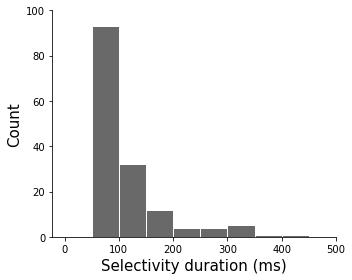

In [63]:
fig,ax = plt.subplots(figsize=(5,4))

ax.hist(df['selectivity_duration'], bins=np.arange(0,500,50), color='dimgray', ec='white');
ax.set_xlabel('Selectivity duration (ms)',fontsize=15);
ax.set_xticks(np.arange(0,600,100))
ax.set_ylabel('Count',fontsize=15);
ax.set_yticks(np.arange(0,120,20))

plt.tight_layout()
#plt.savefig(fig_path / 'selectivity_duration_hist.png', dpi=300,facecolor='white')

### Peak time vs. Selectivity duration: Model fitting

In [14]:
from scipy.optimize import curve_fit

def ln(x,a,b):
    return a*x+b

def poly(x,a,b,c):
    return a*(x**2)+b*x+c

def sigmoid(x,a,b,c,d):
    return d+(c-d)/(1+np.e**(-a*(x-b)))

ln_result, _ = curve_fit(ln,df['peak_selectivity_time'],df['selectivity_duration'])
poly_result, _ = curve_fit(poly,df['peak_selectivity_time'],df['selectivity_duration'])
sigmoid_result, _ = curve_fit(sigmoid,df['peak_selectivity_time'],df['selectivity_duration'])

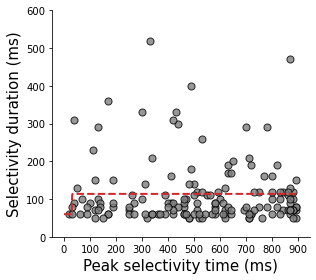

In [52]:
fig,ax = plt.subplots(figsize=(4.5,4))

ax.scatter(df['peak_selectivity_time'],df['selectivity_duration'],
           edgecolors='k',facecolors='tab:gray', s=50, alpha=0.8)
ax.set_ylabel('Selectivity duration (ms)',fontsize=15)
ax.set_yticks(np.arange(0,700,100));
ax.set_ylim([0,600])
ax.set_xlabel('Peak selectivity time (ms)',fontsize=15)
ax.set_xticks(np.arange(0,1000,100));

xline = np.arange(0,900,1)
#ax.plot(xline,ln(xline,ln_result[0],ln_result[1]),color='tab:red',linestyle='-', linewidth=2)
#ax.plot(xline,poly(xline,poly_result[0],poly_result[1],poly_result[2]),
#       color='tab:red',linestyle='-.', linewidth=2)
ax.plot(xline,sigmoid(xline,sigmoid_result[0],sigmoid_result[1],sigmoid_result[2],sigmoid_result[3]),
        color='tab:red',linestyle='--', linewidth=2)

plt.tight_layout()
plt.savefig(fig_path / 'peaktime_duration_scatter.png', dpi=300,facecolor='white')

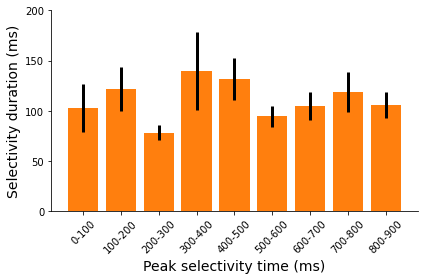

                        Source            SS   DF           MS         F  \
0  peak_selectivity_time_range  3.777693e+04    8  4722.116759  0.680946   
1                       Within  1.005522e+06  145  6934.637356       NaN   

      p-unc       np2  
0  0.707754  0.036209  
1       NaN       NaN  


In [16]:
fig,ax = plt.subplots(figsize=(6,4))

x = range(9)
y = df.groupby('peak_selectivity_time_range').mean()['selectivity_duration']
yerr = df.groupby('peak_selectivity_time_range').sem()['selectivity_duration']

ax.bar(x=x, height=y, color='tab:orange')
ax.errorbar(x=x, y=y, yerr=yerr, fmt='none',color='black', linewidth=3)
ax.set_yticks(np.arange(0,210,50))
ax.set_ylabel('Selectivity duration (ms)',fontsize=14)
ax.set_xlabel('Peak selectivity time (ms)',fontsize=14)
ax.set_xticks(range(9))
ax.set_xticklabels(['0-100','100-200','200-300','300-400','400-500','500-600','600-700','700-800','800-900'])
ax.tick_params(axis='x',labelrotation=45);

plt.tight_layout()
plt.show()
#plt.savefig(fig_path / 'selectivity_duration_bar.png', dpi=300,facecolor='white')


anova_result = pg.anova(data=df, dv='selectivity_duration', between='peak_selectivity_time_range', detailed=True)
print(anova_result)

                         Source            SS   DF           MS         F  \
0  peak_selectivity_time_range2  1.629198e+03    3   543.066048  0.078201   
1                        Within  1.041670e+06  150  6944.467683       NaN   

      p-unc       np2  
0  0.971716  0.001562  
1       NaN       NaN  


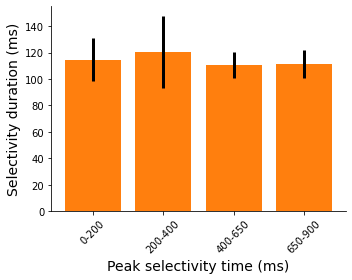

In [54]:
fig,ax = plt.subplots(figsize=(5,4))

x = range(4)
y = df.groupby('peak_selectivity_time_range2').mean()['selectivity_duration']
yerr = df.groupby('peak_selectivity_time_range2').sem()['selectivity_duration']

ax.bar(x=x, height=y, color='tab:orange')
ax.errorbar(x=x, y=y, yerr=yerr, fmt='none',color='black', linewidth=3)
#ax.set_yticks(np.arange(0,210,50))
ax.set_ylabel('Selectivity duration (ms)',fontsize=14)
ax.set_xlabel('Peak selectivity time (ms)',fontsize=14)
ax.set_xticks(range(4))
ax.set_xticklabels(['0-200','200-400','400-650','650-900'])
ax.tick_params(axis='x',labelrotation=45);

plt.tight_layout()
#plt.show()
plt.savefig(fig_path / 'selectivity_duration_bar.png', dpi=300,facecolor='white')

anova_result = pg.anova(data=df, dv='selectivity_duration', between='peak_selectivity_time_range2', detailed=True)
print(anova_result)

In [55]:
pg.anova(data=df, dv='selectivity_duration', between='peak_selectivity_time_range2', detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,peak_selectivity_time_range2,1.629198e+03,3,543.066048,0.078201,0.971716,0.001562
1,Within,1.041670e+06,150,6944.467683,NaN,NaN,NaN


### Peak time vs. Selectivity index: Model fitting

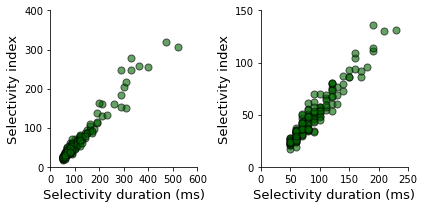

In [40]:
fig,ax = plt.subplots(1,2,figsize=(6,3))
ax[0].scatter(df['selectivity_duration'],df['selectivity_index'],
             edgecolors='k', facecolors='darkgreen',alpha=0.6, s=50)
ax[0].set_xlabel('Selectivity duration (ms)', fontsize=13)
ax[0].set_xticks(np.arange(0,700,100))
ax[0].set_ylabel('Selectivity index',fontsize=13)
ax[0].set_yticks(np.arange(0,500,100))


ax[1].scatter(df['selectivity_duration'],df['selectivity_index'],
             edgecolors='k', facecolors='darkgreen',alpha=0.6, s=50)
ax[1].set_xlabel('Selectivity duration (ms)', fontsize=13)
ax[1].set_xticks(np.arange(0,300,50))
ax[1].set_xlim([0,250])
ax[1].set_ylabel('Selectivity index',fontsize=13)
ax[1].set_yticks(np.arange(0,200,50))
ax[1].set_ylim([0,150])

plt.tight_layout()
plt.savefig(fig_path / 'SI_duration_scatter.png', dpi=300,facecolor='white')

In [15]:
ln_result, _ = curve_fit(ln,df['peak_selectivity_time'],df['selectivity_index'])
poly_result, _ = curve_fit(poly,df['peak_selectivity_time'],df['selectivity_index'])
sigmoid_result, _ = curve_fit(sigmoid,df['peak_selectivity_time'],df['selectivity_index'])

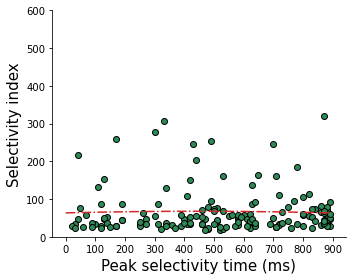

In [39]:
fig,ax = plt.subplots(figsize=(5,4))

ax.scatter(df['peak_selectivity_time'],df['selectivity_index'],edgecolors='k',facecolors='seagreen')
ax.set_ylabel('Selectivity index',fontsize=15)
ax.set_yticks(np.arange(0,700,100));
ax.set_ylim([0,600])
ax.set_xlabel('Peak selectivity time (ms)',fontsize=15)
ax.set_xticks(np.arange(0,1000,100));

xline = np.arange(0,900,1)
#ax.plot(xline,ln(xline,ln_result[0],ln_result[1]),color='tab:red',linestyle=':')
ax.plot(xline,poly(xline,poly_result[0],poly_result[1],poly_result[2]),color='tab:red',linestyle='-.')
#ax.plot(xline,sigmoid(xline,sigmoid_result[0],sigmoid_result[1],
#                      sigmoid_result[2],sigmoid_result[3]),color='tab:red',linestyle='--')

plt.tight_layout()
#plt.savefig(fig_path / 'time_duration_scatter.png', dpi=300,facecolor='white')

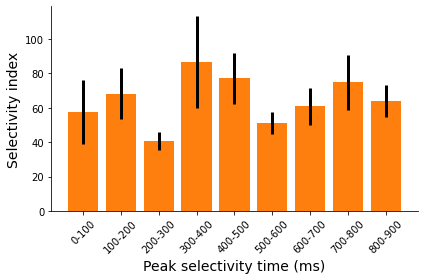

                        Source            SS   DF           MS         F  \
0  peak_selectivity_time_range  3.777693e+04    8  4722.116759  0.680946   
1                       Within  1.005522e+06  145  6934.637356       NaN   

      p-unc       np2  
0  0.707754  0.036209  
1       NaN       NaN  


In [34]:
fig,ax = plt.subplots(figsize=(6,4))

x = range(9)
y = df.groupby('peak_selectivity_time_range').mean()['selectivity_index']
yerr = df.groupby('peak_selectivity_time_range').sem()['selectivity_index']

ax.bar(x=x, height=y, color='tab:orange')
ax.errorbar(x=x, y=y, yerr=yerr, fmt='none',color='black', linewidth=3)
#ax.set_yticks(np.arange(0,210,50))
ax.set_ylabel('Selectivity index',fontsize=14)
ax.set_xlabel('Peak selectivity time (ms)',fontsize=14)
ax.set_xticks(range(9))
ax.set_xticklabels(['0-100','100-200','200-300','300-400','400-500','500-600','600-700','700-800','800-900'])
ax.tick_params(axis='x',labelrotation=45);

plt.tight_layout()
plt.show()
#plt.savefig(fig_path / 'selectivity_duration_bar.png', dpi=300,facecolor='white')


anova_result = pg.anova(data=df, dv='selectivity_duration', between='peak_selectivity_time_range', detailed=True)
print(anova_result)

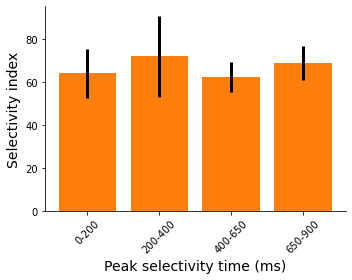

                         Source             SS   DF           MS         F  \
0  peak_selectivity_time_range2    1948.394088    3   649.464696  0.185376   
1                        Within  525523.903918  150  3503.492693       NaN   

      p-unc       np2  
0  0.906214  0.003694  
1       NaN       NaN  


In [36]:
fig,ax = plt.subplots(figsize=(5,4))

x = range(4)
y = df.groupby('peak_selectivity_time_range2').mean()['selectivity_index']
yerr = df.groupby('peak_selectivity_time_range2').sem()['selectivity_index']

ax.bar(x=x, height=y, color='tab:orange')
ax.errorbar(x=x, y=y, yerr=yerr, fmt='none',color='black', linewidth=3)
#ax.set_yticks(np.arange(0,210,50))
ax.set_ylabel('Selectivity index',fontsize=14)
ax.set_xlabel('Peak selectivity time (ms)',fontsize=14)
ax.set_xticks(range(4))
ax.set_xticklabels(['0-200','200-400','400-650','650-900'])
ax.tick_params(axis='x',labelrotation=45);

plt.tight_layout()
plt.show()
plt.savefig(fig_path / 'selectivity_duration_bar.png', dpi=300,facecolor='white')


anova_result = pg.anova(data=df, dv='selectivity_index', between='peak_selectivity_time_range2', detailed=True)
print(anova_result)